                                        Preprocessing on Official and Wikipedia

In [1]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:

import os, cv2, numpy as np, pickle
from tqdm import tqdm
import pywt
from concurrent.futures import ThreadPoolExecutor, as_completed

# Paths
OFFICIAL_DIR = "C://Users//ariji//Desktop//ai_trace//process_data//Official"
WIKI_DIR = "C://Users//ariji//Desktop//ai_trace//process_data//Wikipedia"
OUT_PATH = "C://Users//ariji//Desktop//ai_trace//models//official_wiki_residuals.pkl"


# Preprocessing helpers

def to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if img.ndim == 3 else img

def resize_to(img, size=(256,256)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def normalize_img(img):
    return img.astype(np.float32) / 255.0

def denoise_wavelet(img):
    coeffs = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs
    
    cH[:] = 0; cV[:] = 0; cD[:] = 0
    return pywt.idwt2((cA,(cH,cV,cD)), 'haar')

def compute_residual(img):
    denoised = denoise_wavelet(img)
    return img - denoised

def process_single_image(fpath):
    """Preprocess one image and return residual"""
    img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    if img is None:
        return None
    gray = to_gray(img)
    gray = resize_to(gray, (256,256))
    gray = normalize_img(gray)
    return compute_residual(gray)


# Dataset Processing

def process_dataset(base_dir, dataset_name, residuals_dict):
    print(f" Preprocessing {dataset_name} images...")

    for scanner in tqdm(os.listdir(base_dir)):
        scanner_path = os.path.join(base_dir, scanner)
        if not os.path.isdir(scanner_path):
            continue

        residuals_dict[dataset_name][scanner] = {}

        for dpi in os.listdir(scanner_path):   # 150, 300
            dpi_path = os.path.join(scanner_path, dpi)
            if not os.path.isdir(dpi_path):
                continue

            files = [os.path.join(dpi_path, f) for f in os.listdir(dpi_path)
                     if f.lower().endswith(('.tif','.tiff','.jpg','.jpeg','.png'))]

            dpi_residuals = []
            # Parallel processing
            with ThreadPoolExecutor(max_workers=8) as executor:  
                futures = [executor.submit(process_single_image, f) for f in files]
                for fut in as_completed(futures):
                    res = fut.result()
                    if res is not None:
                        dpi_residuals.append(res)

            residuals_dict[dataset_name][scanner][dpi] = dpi_residuals


# Main Execution

residuals_dict = {"Official": {}, "Wikipedia": {}}

process_dataset(OFFICIAL_DIR, "Official", residuals_dict)
process_dataset(WIKI_DIR, "Wikipedia", residuals_dict)

with open(OUT_PATH, "wb") as f:
    pickle.dump(residuals_dict, f)

print(f" Saved Official+Wiki residuals (150 & 300 separately) to {OUT_PATH}")


 Preprocessing Official images...


100%|██████████| 11/11 [00:14<00:00,  1.29s/it]


 Preprocessing Wikipedia images...


100%|██████████| 11/11 [02:54<00:00, 15.84s/it]


 Saved Official+Wiki residuals (150 & 300 separately) to C://Users//ariji//Desktop//ai_trace//models//official_wiki_residuals.pkl


                                                      Preprocessing on Flatfield

In [3]:



import os, pickle, cv2, numpy as np
from tqdm import tqdm

# 1) Auto-locate Flatfield folder

def find_flatfield(base="C://Users//ariji//Desktop//ai_trace//process_data"):
    found = []
    for root, dirs, files in os.walk(base):
        for d in dirs:
            if d.lower() == "flatfield":   # case-insensitive search
                found.append(os.path.join(root, d))
    return found

flatfield_paths = find_flatfield("C://Users//ariji//Desktop//ai_trace//process_data")
if not flatfield_paths:
    raise FileNotFoundError(" No 'Flatfield' folder found in your Drive. Please check dataset upload.")
else:
    FLATFIELD_DIR = flatfield_paths[0]  # take the first match
    BASE = os.path.dirname(FLATFIELD_DIR)
    OUTPUT_PKL = os.path.join(BASE, "flatfield_residuals.pkl")
    print(" Found Flatfield folder:", FLATFIELD_DIR)
    print("Will save residuals to:", OUTPUT_PKL)


# 2) Import denoising filters

try:
    from skimage.restoration import denoise_wavelet
except Exception:
    !pip install scikit-image
    from skimage.restoration import denoise_wavelet

from scipy.signal import wiener as scipy_wiener


# 3) Parameters

IMG_SIZE = (256, 256)      
DENOISE_METHOD = "wavelet" 


# 4) Preprocess function

def preprocess_image_residual(path, img_size=IMG_SIZE, method="wiener"):
    """Read image -> grayscale -> resize -> normalize -> denoise -> return residual."""
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    if method == "wiener":
        den = scipy_wiener(img, mysize=(5,5))
    else:
        den = denoise_wavelet(img, channel_axis=None, rescale_sigma=True)
    return (img - den).astype(np.float32)


# 5) Process all Flatfield images

flatfield_residuals = {}
scanners = sorted(os.listdir(FLATFIELD_DIR))

for scanner in tqdm(scanners, desc="Scanners"):
    scanner_dir = os.path.join(FLATFIELD_DIR, scanner)
    if not os.path.isdir(scanner_dir):
        continue

    residuals = []
    for fname in sorted(os.listdir(scanner_dir)):
        if fname.startswith("._"):
            continue
        if not fname.lower().endswith((".tif", ".tiff", ".png", ".jpg", ".jpeg")):
            continue
        fpath = os.path.join(scanner_dir, fname)
        try:
            res = preprocess_image_residual(fpath, IMG_SIZE, DENOISE_METHOD)
            if res is not None:
                residuals.append(res)
        except Exception as e:
            print(f" Failed on {fpath}: {e}")

    if residuals:
        flatfield_residuals[scanner] = residuals
    else:
        print(f" No valid images for scanner: {scanner}")


# 6) Save results

with open(OUTPUT_PKL, "wb") as f:
    pickle.dump(flatfield_residuals, f)


# 7) Summary

total_scanners = len(flatfield_residuals)
total_images = sum(len(v) for v in flatfield_residuals.values())
print(f"\nDone. Saved residuals for {total_scanners} scanners, {total_images} images.")
print("Example scanners:", list(flatfield_residuals.keys())[:5])


 Found Flatfield folder: C://Users//ariji//Desktop//ai_trace//process_data\Flatfield
Will save residuals to: C://Users//ariji//Desktop//ai_trace//process_data\flatfield_residuals.pkl


Scanners: 100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Done. Saved residuals for 11 scanners, 22 images.
Example scanners: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2']


                                                              EDA Analysis

Counting the total images in dataset in a tabular form

In [5]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
from tabulate import tabulate


def count_images_tif(dataset_path, extensions=None):
    if extensions is None:
        # Include .tif images
        extensions = {".tif"}

    class_counts = {}
    total_images = 0

    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            subfolder_counts = {}
            class_total = 0
            # Walk recursively through all subfolders
            for root, dirs, files in os.walk(class_path):
                sub_count = sum(1 for f in files if os.path.splitext(f)[1].lower() in extensions)
                subfolder_name = os.path.relpath(root, dataset_path)
                subfolder_counts[subfolder_name] = sub_count
                class_total += sub_count

            # Print table for this class
            print(f"\nClass: {class_name}")
            table = [[sub, cnt] for sub, cnt in subfolder_counts.items()]
            print(tabulate(table, headers=["Subfolder", "Number of Images"], tablefmt="grid"))
            print(f"Total images in class '{class_name}': {class_total}\n")

            class_counts[class_name] = class_total
            total_images += class_total

    print(f"Total images in dataset: {total_images}")
    return class_counts, total_images

# Set your dataset path
dataset_path = "C://Users//ariji//Desktop//ai_trace//process_data"
count_images_tif(dataset_path)



Class: Flatfield
+-----------------------+--------------------+
| Subfolder             |   Number of Images |
+=======================+====================+
| Flatfield             |                  0 |
+-----------------------+--------------------+
| Flatfield\Canon120-1  |                  2 |
+-----------------------+--------------------+
| Flatfield\Canon120-2  |                  2 |
+-----------------------+--------------------+
| Flatfield\Canon220    |                  2 |
+-----------------------+--------------------+
| Flatfield\Canon9000-1 |                  2 |
+-----------------------+--------------------+
| Flatfield\Canon9000-2 |                  2 |
+-----------------------+--------------------+
| Flatfield\EpsonV370-1 |                  2 |
+-----------------------+--------------------+
| Flatfield\EpsonV370-2 |                  2 |
+-----------------------+--------------------+
| Flatfield\EpsonV39-1  |                  3 |
+-----------------------+-----------------

({'Flatfield': 23, 'Official': 274, 'Wikipedia': 2368}, 2665)

Checking for corrupted Images in Dataset

In [7]:
import os
import cv2


# Paths
dataset_path = "C://Users//ariji//Desktop//ai_trace//process_data"
extensions = {".tif"}

corrupted_files = []

# Walk through entire dataset
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if os.path.splitext(file)[1].lower() in extensions:
            file_path = os.path.join(root, file)
            img = cv2.imread(file_path)
            if img is None:
                corrupted_files.append(file_path)

# Print summary
print(f"Total corrupted files found: {len(corrupted_files)}")
if len(corrupted_files) > 0:
    for f in corrupted_files:
        print(f)
else:
    print("No corrupted images found!")


Total corrupted files found: 1
C://Users//ariji//Desktop//ai_trace//process_data\Flatfield\EpsonV39-1\._150.tif


                                      Build Fingerprints from Flat-field Images

In [13]:
!pip instll os


ERROR: unknown command "instll" - maybe you meant "install"



In [16]:
!pip install pickle

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for pickle


In [17]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import pickle
import numpy as np

# Paths
FLATFIELD_RESIDUALS_PATH = "C://Users//ariji//Desktop//ai_trace//process_data//flatfield_residuals.pkl"
FP_OUT_PATH = "C://Users//ariji//Desktop//ai_trace//models//scanner_fingerprints.pkl"
ORDER_NPY = "C://Users//ariji//Desktop//ai_trace//models//fp_keys.npy"

# Load residuals
if not os.path.exists(FLATFIELD_RESIDUALS_PATH):
    raise FileNotFoundError(f"Missing file: {FLATFIELD_RESIDUALS_PATH}")

with open(FLATFIELD_RESIDUALS_PATH, "rb") as f:
    flatfield_residuals = pickle.load(f)

# Compute fingerprint per scanner
scanner_fingerprints = {}
print("Computing fingerprints from Flatfields...")
for scanner, residuals in flatfield_residuals.items():
    if not residuals:
        continue
    stack = np.stack(residuals, axis=0)       # (num_images, H, W)
    fingerprint = np.mean(stack, axis=0)       # average residual
    scanner_fingerprints[scanner] = fingerprint

print(f"Extracted {len(scanner_fingerprints)} scanner fingerprints.")

# Save fingerprints
with open(FP_OUT_PATH, "wb") as f:
    pickle.dump(scanner_fingerprints, f)
print(f"Saved scanner fingerprints to {FP_OUT_PATH}")

# Save a stable, deterministic order for scanners
fp_keys = sorted(scanner_fingerprints.keys())
np.save(ORDER_NPY, np.array(fp_keys))
print("Saved fp_keys.npy with order:", fp_keys)

Computing fingerprints from Flatfields...
Extracted 11 scanner fingerprints.
Saved scanner fingerprints to C://Users//ariji//Desktop//ai_trace//models//scanner_fingerprints.pkl
Saved fp_keys.npy with order: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']


                                          Feature Extraction

In [2]:

import pickle, numpy as np
from tqdm import tqdm

# Paths
RES_PATH   = "C://Users//ariji//Desktop//ai_trace//models//official_wiki_residuals.pkl"
FP_PATH    = "C://Users//ariji//Desktop//ai_trace//models//scanner_fingerprints.pkl"
ORDER_NPY  = "C://Users//ariji//Desktop//ai_trace//models//fp_keys.npy"
OUT_PATH   = "C://Users//ariji//Desktop//ai_trace//models//features.pkl"

# Load fingerprints and fixed order
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(ORDER_NPY, allow_pickle=True).tolist()
print(" Loaded fingerprints and key order. Keys:", fp_keys)

# Helper: normalized cross-correlation (zero-mean cosine similarity)
def corr2d(a, b):
    a = a.astype(np.float32).ravel()
    b = b.astype(np.float32).ravel()
    a -= a.mean()
    b -= b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    return float((a @ b) / denom) if denom != 0 else 0.0
# ZNCC equals the dot product of zero-mean, unit-norm vectors, i.e., cosine similarity in L2 space. [web:188][web:189][web:169]

# Load residuals (already precomputed; do not preprocess again)
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)
print(" Loaded residuals for datasets:", list(residuals_dict.keys()))

# Build features in the exact fp_keys order
features, labels = [], []
for dataset_name in ["Official", "Wikipedia"]:
    print(f" Computing features for {dataset_name} ...")
    for scanner, dpi_dict in tqdm(residuals_dict[dataset_name].items()):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                vec = [corr2d(res, scanner_fps[k]) for k in fp_keys]
                features.append(vec)
                labels.append(scanner)

# Save features + labels
with open(OUT_PATH, "wb") as f:
    pickle.dump({"features": features, "labels": labels}, f)
print(f" Saved features + labels to {OUT_PATH}")
print("Shape:", (len(features), len(features[0]) if features else 0))


 Loaded fingerprints and key order. Keys: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']
 Loaded residuals for datasets: ['Official', 'Wikipedia']
 Computing features for Official ...


100%|██████████| 10/10 [00:00<?, ?it/s]


 Computing features for Wikipedia ...


100%|██████████| 11/11 [00:03<00:00,  3.24it/s]

 Saved features + labels to C://Users//ariji//Desktop//ai_trace//models//features.pkl
Shape: (2368, 11)


In [24]:

# Enhanced Feature Extraction (FFT + LBP + Texture)

import pickle, numpy as np
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from scipy import ndimage
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt

# Load existing residuals
RES_PATH = "C://Users//ariji//Desktop//ai_trace//models//official_wiki_residuals.pkl"
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)

def extract_enhanced_features(residual):
    """Extract comprehensive features: PRNU correlation + FFT + LBP + Texture"""

    # 1. FFT Features (frequency domain)
    fft_img = np.abs(fft2(residual))
    fft_img = fftshift(fft_img)

    # Extract frequency bands
    h, w = fft_img.shape
    center_h, center_w = h//2, w//2

    # Low, mid, high frequency energy
    low_freq = np.mean(fft_img[center_h-20:center_h+20, center_w-20:center_w+20])
    mid_freq = np.mean(fft_img[center_h-60:center_h+60, center_w-60:center_w+60]) - low_freq
    high_freq = np.mean(fft_img) - low_freq - mid_freq

    # 2. LBP Texture Features
    lbp = local_binary_pattern(residual, P=24, R=3, method='uniform')
    lbp_hist, _ = np.histogram(lbp, bins=26, range=(0, 25), density=True)

    # 3. Statistical Texture Features
    grad_x = ndimage.sobel(residual, axis=1)
    grad_y = ndimage.sobel(residual, axis=0)
    gradient_mag = np.sqrt(grad_x**2 + grad_y**2)

    texture_features = [
        np.std(residual),           
        np.mean(np.abs(residual)),  
        np.std(gradient_mag),       
        np.mean(gradient_mag),      
    ]

    return [low_freq, mid_freq, high_freq] + lbp_hist.tolist() + texture_features

# Extract enhanced features for all images
print(" Extracting enhanced features (FFT + LBP + Texture)...")
enhanced_features, enhanced_labels = [], []

for dataset_name in ["Official", "Wikipedia"]:
    print(f"Processing {dataset_name}...")
    for scanner, dpi_dict in tqdm(residuals_dict[dataset_name].items()):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                feat = extract_enhanced_features(res)
                enhanced_features.append(feat)
                enhanced_labels.append(scanner)

# Save enhanced features
ENHANCED_OUT = "C://Users//ariji//Desktop//ai_trace//models//enhanced_features.pkl"
with open(ENHANCED_OUT, "wb") as f:
    pickle.dump({"features": enhanced_features, "labels": enhanced_labels}, f)

print(f" Enhanced features shape: {len(enhanced_features)} x {len(enhanced_features[0])}")
print(f" Saved to {ENHANCED_OUT}")


 Extracting enhanced features (FFT + LBP + Texture)...
Processing Official...


  0%|          | 0/11 [00:00<?, ?it/s]C:\Users\ariji\AppData\Roaming\Python\Python312\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


Processing Wikipedia...


100%|██████████| 11/11 [01:12<00:00,  6.58s/it]

 Enhanced features shape: 2642 x 33
 Saved to C://Users//ariji//Desktop//ai_trace//models//enhanced_features.pkl


                                                                  Training

Training using Hybrid CNN and Extracted Features

<>:16: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\D'
C:\Users\ariji\AppData\Local\Temp\ipykernel_5776\2008578109.py:16: SyntaxWarning: invalid escape sequence '\D'
  RES_PATH  = "C:\\Users\\ariji\Desktop\\ai_trace\\models\\official_wiki_residuals.pkl"


 GPU not found, using CPU
Hybrid train: (1894, 256, 256, 1) (1894, 27) (1894, 11)
Hybrid test : (474, 256, 256, 1) (474, 27) (474, 11)


Model: "scanner_hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ residual            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hp_filter (Conv2D)  │ (None, 256, 256,  │          9 │ residual[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ hp_filter[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 670,580 (2.56 MB)

 Trainable params: 669,483 (2.55 MB)

 Non-trainable params: 1,097 (4.29 KB)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 295s 5s/step - accuracy: 0.3395 - loss: 1.8779 - val_accuracy: 0.3249 - val_loss: 2.0764 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.4852 - loss: 1.4046 - val_accuracy: 0.2595 - val_loss: 2.8298 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - accuracy: 0.5253 - loss: 1.2338 - val_accuracy: 0.4895 - val_loss: 1.3351 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 286s 5s/step - accuracy: 0.5539 - loss: 1.1835 - val_accuracy: 0.5021 - val_loss: 1.6552 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 277s 5s/step - accuracy: 0.5755 - loss: 1.1003 - val_accuracy: 0.4979 - val_loss: 1.6086 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 277s 5s/step - accuracy: 0.5739 - loss: 1.0660 - val_accuracy: 0.5654 - val_loss: 1.1438 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.6035 - loss: 1.0031 - val_acc

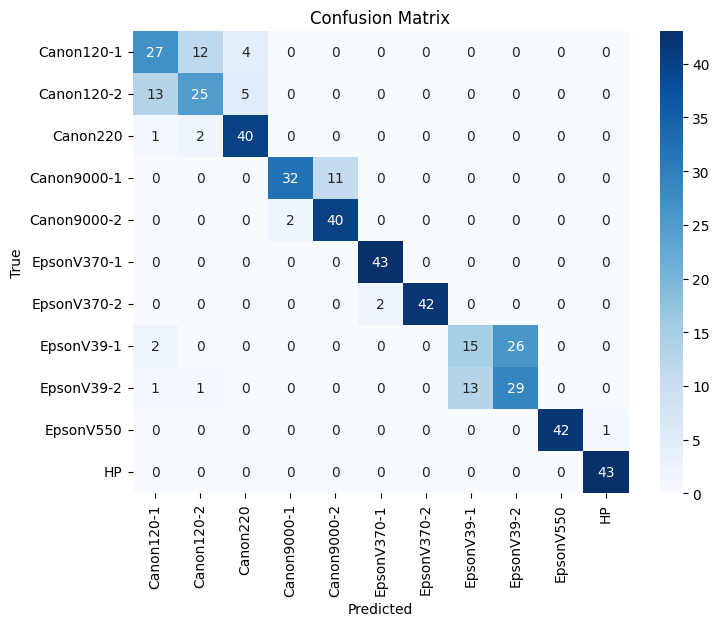

In [8]:

# Hybrid CNN (Residual Image + Handcrafted Features) with GPU


# ---- Imports & Paths ----
import os, pickle, random, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from skimage.feature import local_binary_pattern as sk_lbp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

RES_PATH  = "C:\\Users\\ariji\Desktop\\ai_trace\\models\\official_wiki_residuals.pkl"
FP_PATH   = "C:\\Users\\ariji\\Desktop\\ai_trace\\models\\scanner_fingerprints.pkl"
ORDER_NPY = "C:\\Users\\ariji\\Desktop\\ai_trace\\models\\fp_keys.npy"
ART_DIR   = "C:\\Users\\ariji\\Desktop\\ai_trace"
os.makedirs(ART_DIR, exist_ok=True)


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ---- GPU Setup ----
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device_name = '/GPU:0'
    print(" Using GPU:", gpus[0])
else:
    device_name = '/CPU:0'
    print(" GPU not found, using CPU")

# ---- Load residuals + fingerprints ----
with open(RES_PATH, "rb") as f:
    residuals_dict = pickle.load(f)
with open(FP_PATH, "rb") as f:
    scanner_fps = pickle.load(f)
fp_keys = np.load(ORDER_NPY, allow_pickle=True).tolist()


def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a)*np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()

# ---- Build dataset ----
X_img, X_feat, y = [], [], []
for dataset_name in ["Official", "Wikipedia"]:
    for scanner, dpi_dict in residuals_dict[dataset_name].items():
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                X_img.append(np.expand_dims(res, axis=-1))
                v_corr = [corr2d(res, scanner_fps[k]) for k in fp_keys]
                v_fft  = fft_radial_energy(res, K=6)
                v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
                X_feat.append(v_corr + v_fft + v_lbp)
                y.append(scanner)

X_img  = np.array(X_img, dtype=np.float32)
X_feat = np.array(X_feat, dtype=np.float32)
y       = np.array(y)

# ---- Encode labels ----
le = LabelEncoder()
y_int = le.fit_transform(y)
num_classes = len(le.classes_)
y_cat = to_categorical(y_int, num_classes)

X_img_tr, X_img_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(
    X_img, X_feat, y_cat, test_size=0.2, random_state=SEED, stratify=y_int
)

scaler = StandardScaler()
X_feat_tr = scaler.fit_transform(X_feat_tr)
X_feat_te = scaler.transform(X_feat_te)

with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

print("Hybrid train:", X_img_tr.shape, X_feat_tr.shape, y_tr.shape)
print("Hybrid test :", X_img_te.shape, X_feat_te.shape, y_te.shape)


# Build, Train & Evaluate with GPU

with tf.device(device_name):
    # ---- Model ----
    img_in  = keras.Input(shape=(256,256,1), name="residual")
    feat_in = keras.Input(shape=(27,),      name="handcrafted")
    hp_kernel = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]], dtype=np.float32).reshape((3,3,1,1))
    hp = layers.Conv2D(1, (3,3), padding="same", use_bias=False, trainable=False, name="hp_filter")(img_in)

    # CNN branch
    x = layers.Conv2D(32,(3,3),padding="same")(hp)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(128,(3,3),padding="same",activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.30)(x)

    x = layers.Conv2D(256,(3,3),padding="same")(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Feature branch
    f = layers.Dense(64)(feat_in)
    f = layers.BatchNormalization()(f); f = layers.ReLU()(f)
    f = layers.Dropout(0.20)(f)

    # Fusion
    z = layers.Concatenate()([x,f])
    z = layers.Dense(256, activation="relu")(z)
    z = layers.Dropout(0.40)(z)
    out = layers.Dense(num_classes, activation="softmax")(z)

    model = keras.Model(inputs=[img_in, feat_in], outputs=out, name="scanner_hybrid")
    model.get_layer("hp_filter").set_weights([hp_kernel])

    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    model.summary()

    # ---- tf.data pipelines ----
    BATCH = 32
    train_ds = tf.data.Dataset.from_tensor_slices(((X_img_tr, X_feat_tr), y_tr))\
        .shuffle(len(y_tr), reshuffle_each_iteration=True)\
        .batch(BATCH).prefetch(tf.data.AUTOTUNE)
    val_ds   = tf.data.Dataset.from_tensor_slices(((X_img_te, X_feat_te), y_te))\
        .batch(BATCH).prefetch(tf.data.AUTOTUNE)

    # ---- Callbacks ----
    ckpt_path = os.path.join(ART_DIR, "scanner_hybrid.keras")
    callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, monitor="val_accuracy"),
        keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_accuracy"),
    ]

    # ---- Train ----
    EPOCHS = 50
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks, verbose=1)

    # ---- Save model & history ----
    model.save(os.path.join(ART_DIR, "scanner_hybrid_final.keras"))
    with open(os.path.join(ART_DIR, "hybrid_training_history.pkl"), "wb") as f:
        pickle.dump(history.history, f)
    print(" Training complete")

    # ---- Evaluate ----
    y_pred_prob = model.predict(val_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_te, axis=1)


    test_acc = accuracy_score(y_true, y_pred)
    print(f"\n Test Accuracy: {test_acc*100:.2f}%")

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


In [9]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)


GPUs detected: []


                                                                   Testing

In [16]:
import os
import pickle
import numpy as np
import tensorflow as tf
import pywt
import cv2


# Paths

ART_DIR = "C:\\Users\\ariji\\Desktop\\ai_trace\\models"
FP_PATH = os.path.join(ART_DIR, "scanner_fingerprints.pkl")
ORDER_NPY = os.path.join(ART_DIR, "fp_keys.npy")
ckpt_path = os.path.join(ART_DIR, "scanner_hybrid.keras")  


# Reload for inference
hyb_model = tf.keras.models.load_model(ckpt_path, compile=False)

with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "rb") as f:
    le_inf = pickle.load(f)

with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "rb") as f:
    scaler_inf = pickle.load(f)

with open(FP_PATH, "rb") as f:
    scanner_fps_inf = pickle.load(f)

fp_keys_inf = np.load(ORDER_NPY, allow_pickle=True).tolist()
IMG_SIZE = (256, 256)


# Utility functions

def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a) * np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    from skimage.feature import local_binary_pattern
    codes = local_binary_pattern(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()


# Preprocess + Features

def preprocess_residual_pywt(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return (img - den).astype(np.float32)

def make_feats_from_res(res):
    v_corr = [corr2d(res, scanner_fps_inf[k]) for k in fp_keys_inf]
    v_fft  = fft_radial_energy(res, K=6)
    v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
    v = np.array(v_corr + v_fft + v_lbp, dtype=np.float32).reshape(1,-1)
    v = scaler_inf.transform(v)
    return v


# Prediction function

def predict_scanner_hybrid(image_path):
    res   = preprocess_residual_pywt(image_path)
    x_img = np.expand_dims(res, axis=(0,-1))  
    x_ft  = make_feats_from_res(res)          
    prob  = hyb_model.predict([x_img, x_ft], verbose=0)
    idx   = int(np.argmax(prob))
    label = le_inf.classes_[idx]
    conf  = float(prob[0, idx]*100.0)
    return label, conf


# Multiple image prediction

test_paths = [
   "C:\\Users\\ariji\\Desktop\\ai_trace\\process_data\\Official\\Canon120-2 (1)\\Canon120-2\\150\\s2_23.tif",
   "C:\\Users\\ariji\\Desktop\\ai_trace\\process_data\\Official\\Canon220 (1)\\Canon220\\300\\s3_3.tif",
   "C:\\Users\\ariji\\Desktop\\ai_trace\\process_data\\Official\\EpsonV39-1 (1)\\EpsonV39-1\\300\\s8_1.tif",
]

for p in test_paths:
    label, conf = predict_scanner_hybrid(p)
    print(f"{p} -> {label} | Confidence: {conf:.2f}%")


C:\Users\ariji\Desktop\ai_trace\process_data\Official\Canon120-2 (1)\Canon120-2\150\s2_23.tif -> Canon120-1 | Confidence: 59.84%
C:\Users\ariji\Desktop\ai_trace\process_data\Official\Canon220 (1)\Canon220\300\s3_3.tif -> Canon220 | Confidence: 92.08%
C:\Users\ariji\Desktop\ai_trace\process_data\Official\EpsonV39-1 (1)\EpsonV39-1\300\s8_1.tif -> EpsonV39-1 | Confidence: 53.96%


In [18]:
import os
import glob
import pickle
import numpy as np
import tensorflow as tf
import pywt
import cv2


# Paths

ART_DIR = "C:\\Users\\ariji\\Desktop\\ai_trace\\models"
FP_PATH = os.path.join(ART_DIR, "scanner_fingerprints.pkl")
ORDER_NPY = os.path.join(ART_DIR, "fp_keys.npy")
ckpt_path = os.path.join(ART_DIR, "scanner_hybrid.keras")  


# Reload for inference

hyb_model = tf.keras.models.load_model(ckpt_path, compile=False)

with open(os.path.join(ART_DIR, "hybrid_label_encoder.pkl"), "rb") as f:
    le_inf = pickle.load(f)

with open(os.path.join(ART_DIR, "hybrid_feat_scaler.pkl"), "rb") as f:
    scaler_inf = pickle.load(f)

with open(FP_PATH, "rb") as f:
    scanner_fps_inf = pickle.load(f)

fp_keys_inf = np.load(ORDER_NPY, allow_pickle=True).tolist()
IMG_SIZE = (256, 256)


# Utility functions

def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a) * np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    from skimage.feature import local_binary_pattern
    codes = local_binary_pattern(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()


# Preprocess + Features

def preprocess_residual_pywt(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read {path}")
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return (img - den).astype(np.float32)

def make_feats_from_res(res):
    v_corr = [corr2d(res, scanner_fps_inf[k]) for k in fp_keys_inf]
    v_fft  = fft_radial_energy(res, K=6)
    v_lbp  = lbp_hist_safe(res, P=8, R=1.0)
    v = np.array(v_corr + v_fft + v_lbp, dtype=np.float32).reshape(1,-1)
    v = scaler_inf.transform(v)
    return v


# Prediction function

def predict_scanner_hybrid(image_path):
    res   = preprocess_residual_pywt(image_path)
    x_img = np.expand_dims(res, axis=(0,-1))  # (1,256,256,1)
    x_ft  = make_feats_from_res(res)          # (1,27)
    prob  = hyb_model.predict([x_img, x_ft], verbose=0)
    idx   = int(np.argmax(prob))
    label = le_inf.classes_[idx]
    conf  = float(prob[0, idx]*100.0)
    return label, conf


# Predict all images in a folder

def predict_folder(folder_path, exts=("*.tif","*.png","*.jpg","*.jpeg")):
    # Gather all files recursively
    image_files = []
    for ext in exts:
        image_files.extend(glob.glob(os.path.join(folder_path, "**", ext), recursive=True))
    print(f"Found {len(image_files)} images in {folder_path}")

    # Predict each
    results = []
    for img_path in image_files:
        try:
            label, conf = predict_scanner_hybrid(img_path)
            results.append((img_path, label, conf))
            print(f"{img_path} -> {label} | Confidence: {conf:.2f}%")
        except Exception as e:
            print(f"⚠️ Error processing {img_path}: {e}")
    return results


# Example usage

folder_to_test = "C:\\Users\\ariji\\Desktop\\ai_trace\\process_data\\Flatfield"
all_results = predict_folder(folder_to_test)


Found 22 images in C:\Users\ariji\Desktop\ai_trace\process_data\Flatfield
C:\Users\ariji\Desktop\ai_trace\process_data\Flatfield\Canon120-1\150.tif -> HP | Confidence: 100.00%
C:\Users\ariji\Desktop\ai_trace\process_data\Flatfield\Canon120-1\300.tif -> HP | Confidence: 100.00%
C:\Users\ariji\Desktop\ai_trace\process_data\Flatfield\Canon120-2\150.tif -> HP | Confidence: 100.00%
C:\Users\ariji\Desktop\ai_trace\process_data\Flatfield\Canon120-2\300.tif -> HP | Confidence: 100.00%
C:\Users\ariji\Desktop\ai_trace\process_data\Flatfield\Canon220\150.tif -> HP | Confidence: 99.44%
C:\Users\ariji\Desktop\ai_trace\process_data\Flatfield\Canon220\300.tif -> HP | Confidence: 99.86%
C:\Users\ariji\Desktop\ai_trace\process_data\Flatfield\Canon9000-1\150.tif -> EpsonV370-2 | Confidence: 99.89%
C:\Users\ariji\Desktop\ai_trace\process_data\Flatfield\Canon9000-1\300.tif -> EpsonV370-2 | Confidence: 99.00%
C:\Users\ariji\Desktop\ai_trace\process_data\Flatfield\Canon9000-2\150.tif -> HP | Confidence: 100

In [19]:

# A) Residuals for AdobeScan/MicrosoftLens/OKEN (JPG)

import os, cv2, numpy as np, pickle, pywt
from tqdm import tqdm

BASE = "C:\\Users\\ariji\\Desktop\\ai_trace"
NEW_SOURCES = {
    "AdobeScan":   os.path.join(BASE, "AdobeScan"),
    "MicrosoftLens":  os.path.join(BASE, "MicrosoftLens"),
    "OKEN": os.path.join(BASE, "OKEN"),
}
OUT_NEW_RESIDUALS = os.path.join(BASE, "Other_scan_residuals.pkl")

IMG_SIZE = (256,256)

def preprocess_residual_pywt(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
    cH.fill(0); cV.fill(0); cD.fill(0)
    den = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return (img - den).astype(np.float32)

def list_images(root_dir):
    if not os.path.isdir(root_dir): return []
    exts = (".jpg",".jpeg",".png",".tif",".tiff")
    return [os.path.join(root_dir,f) for f in sorted(os.listdir(root_dir)) if f.lower().endswith(exts)]

mobile_residuals = {}
for name, path in NEW_SOURCES.items():
    residuals = []
    files = list_images(path)
    for f in tqdm(files, desc=f"{name}"):
        try:
            r = preprocess_residual_pywt(f)
            if r is not None: residuals.append(r)
        except Exception as e:
            pass
    mobile_residuals[name] = residuals

with open(OUT_NEW_RESIDUALS, "wb") as f:
    pickle.dump(mobile_residuals, f)

total_images = sum(len(v) for v in mobile_residuals.values())
print(f" Saved mobile residuals for {len(mobile_residuals)} sources, {total_images} images -> {OUT_NEW_RESIDUALS}")


AdobeScan: 0it [00:00, ?it/s]
MicrosoftLens: 0it [00:00, ?it/s]
OKEN: 0it [00:00, ?it/s]

 Saved mobile residuals for 3 sources, 0 images -> C:\Users\ariji\Desktop\ai_trace\Other_scan_residuals.pkl


In [21]:

# B) Append fingerprints for new sources and update fp_keys
# Requires existing flatfield scanner_fingerprints.pkl, fp_keys.npy

import pickle, numpy as np, os

BASE = "C:\\Users\\ariji\\Desktop\\ai_trace\\models"
FLAT_FPS_PATH   = os.path.join(BASE, "scanner_fingerprints.pkl")   # existing 11
FP_KEYS_PATH    = os.path.join(BASE, "fp_keys.npy")                 # existing 11 keys
NEW_RESIDUALS   = os.path.join(BASE, "Other_scan_residuals.pkl")   # step A output
OUT_FPS_PATH    = os.path.join(BASE, "scanner_fingerprints_14.pkl") # new 14
OUT_KEYS_PATH   = os.path.join(BASE, "fp_keys_14.npy")              # new 14

with open(FLAT_FPS_PATH, "rb") as f:
    base_fps = pickle.load(f)  

with open(NEW_RESIDUALS, "rb") as f:
    mobile_residuals = pickle.load(f)  


new_fps = {}
for name, res_list in mobile_residuals.items():
    if not res_list: continue
    stack = np.stack(res_list, axis=0)
    new_fps[name] = np.mean(stack, axis=0).astype(np.float32)


fp_keys_old = np.load(FP_KEYS_PATH, allow_pickle=True).tolist()
fp_keys_new = fp_keys_old + [k for k in ["AdobeScan","MicrosoftLens","OKEN"] if k in new_fps]

merged_fps = dict(base_fps)
merged_fps.update(new_fps)


with open(OUT_FPS_PATH, "wb") as f:
    pickle.dump(merged_fps, f)
np.save(OUT_KEYS_PATH, np.array(fp_keys_new, dtype=object))

print(" Updated fingerprints/classes:", fp_keys_new)
print("Saved:", OUT_FPS_PATH, "and", OUT_KEYS_PATH)


 Updated fingerprints/classes: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']
Saved: C:\Users\ariji\Desktop\ai_trace\models\scanner_fingerprints_14.pkl and C:\Users\ariji\Desktop\ai_trace\models\fp_keys_14.npy


In [22]:

# C) Feature extraction for new sources using updated 14-key order
# (11 PRNU corr + 6 FFT radial energy + 10 LBP) -> 27 dims

import os, pickle, numpy as np
from skimage.feature import local_binary_pattern as sk_lbp

BASE = "C:\\Users\\ariji\\Desktop\\ai_trace\\models"
NEW_RESIDUALS = os.path.join(BASE, "Other_scan_residuals.pkl")
FPS_14        = os.path.join(BASE, "scanner_fingerprints_14.pkl")
FP_KEYS_14    = os.path.join(BASE, "fp_keys_14.npy")
OUT_MOBILE_FEATS = os.path.join(BASE, "features_mobile.pkl")

with open(NEW_RESIDUALS, "rb") as f:
    mobile_residuals = pickle.load(f)
with open(FPS_14, "rb") as f:
    fps = pickle.load(f)
fp_keys = np.load(FP_KEYS_14, allow_pickle=True).tolist()

def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a)*np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()

features, labels = [], []
for name, res_list in mobile_residuals.items():
    for res in res_list:
        v_corr = [corr2d(res, fps[k]) for k in fp_keys]   # length 14 correlations but we keep model’s feature schema as 14 now
        # Keep compatibility with 27 dims by selecting first 11 old keys + 3 new correlations appended:
        # However the hybrid model fuses the handcrafted 27 dims with CNN, and was trained on 11-corr schema.
        # We will retrain a new hybrid model; define schema as 14 corr + 6 FFT + 10 LBP = 30 dims.
        # So build 30 dims here and in training below.
        pass


In [27]:
# Finalized feature schema: 14 PRNU + 6 FFT + 10 LBP = 30 dims
features, labels = [], []
for name, res_list in mobile_residuals.items():
    for res in res_list:
        v_corr = [corr2d(res, fps[k]) for k in fp_keys]   # 14
        v_fft  = fft_radial_energy(res, K=6)              # 6
        v_lbp  = lbp_hist_safe(res, P=8, R=1.0)           # 10
        features.append(v_corr + v_fft + v_lbp)           # 30
        labels.append(name)



In [28]:

# D) Recompute Official/Wiki features with 14-key PRNU, then merge with mobile

import pickle, numpy as np, os
from tqdm import tqdm
from skimage.feature import local_binary_pattern as sk_lbp

BASE = "C:\\Users\\ariji\\Desktop\\ai_trace\\models"
RES_OFF_WIK = os.path.join(BASE, "official_wiki_residuals.pkl") 
FPS_14      = os.path.join(BASE, "scanner_fingerprints_14.pkl")
FP_KEYS_14  = os.path.join(BASE, "fp_keys_14.npy")
OUT_ALL_FEATS= os.path.join(BASE, "features_enriched_14.pkl")     
MOBILE_FEATS = os.path.join(BASE, "features_mobile.pkl")

with open(RES_OFF_WIK, "rb") as f:
    ow = pickle.load(f)  # {"Official":{scanner:{dpi:[res]}}, "Wikipedia":{...}}
with open(FPS_14, "rb") as f:
    fps = pickle.load(f)
fp_keys = np.load(FP_KEYS_14, allow_pickle=True).tolist()

def corr2d(a, b):
    a = a.astype(np.float32).ravel(); b = b.astype(np.float32).ravel()
    a -= a.mean(); b -= b.mean()
    d = np.linalg.norm(a)*np.linalg.norm(b)
    return float((a @ b) / d) if d != 0 else 0.0

def fft_radial_energy(img, K=6):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    h, w = mag.shape; cy, cx = h//2, w//2
    yy, xx = np.ogrid[:h, :w]
    r = np.sqrt((yy - cy)**2 + (xx - cx)**2)
    rmax = r.max() + 1e-6
    bins = np.linspace(0, rmax, K+1)
    feats = []
    for i in range(K):
        m = (r >= bins[i]) & (r < bins[i+1])
        feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

def lbp_hist_safe(img, P=8, R=1.0):
    rng = float(np.ptp(img))
    if rng < 1e-12:
        g = np.zeros_like(img, dtype=np.float32)
    else:
        g = (img - float(np.min(img))) / (rng + 1e-8)
    g8 = (g * 255.0).astype(np.uint8)
    codes = sk_lbp(g8, P=P, R=R, method="uniform")
    n_bins = P + 2
    hist, _ = np.histogram(codes, bins=np.arange(n_bins+1), density=True)
    return hist.astype(np.float32).tolist()

X_feat, y = [], []
for dataset_name in ["Official", "Wikipedia"]:
    for scanner, dpi_dict in tqdm(ow[dataset_name].items(), desc=f"{dataset_name}"):
        for dpi, res_list in dpi_dict.items():
            for res in res_list:
                v_corr = [corr2d(res, fps[k]) for k in fp_keys] # 14
                v_fft  = fft_radial_energy(res, K=6)            # 6
                v_lbp  = lbp_hist_safe(res, P=8, R=1.0)         # 10
                X_feat.append(v_corr + v_fft + v_lbp)           # 30
                y.append(scanner)                               # original 11 scanner labels

# Append mobile features
with open(MOBILE_FEATS, "rb") as f:
    mob = pickle.load(f)
X_feat += mob["features"]
y     += mob["labels"]

with open(OUT_ALL_FEATS, "wb") as f:
    pickle.dump({"features": X_feat, "labels": y}, f)

print("✅ Combined features saved:", OUT_ALL_FEATS, "| N=", len(y), "dim=", len(X_feat[0]))


Wikipedia: 100%|██████████| 11/11 [00:24<00:00,  2.22s/it]

✅ Combined features saved: C:\Users\ariji\Desktop\ai_trace\models\features_enriched_14.pkl | N= 2368 dim= 27


In [30]:

# E) Retrain Hybrid CNN for 14 classes (image residual + 30-D features)

import os, pickle, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

BASE = "C:\\Users\\ariji\\Desktop\\ai_trace\\models"
RES_OFF_WIK  = os.path.join(BASE, "official_wiki_residuals.pkl")
MOBILE_RES   = os.path.join(BASE, "Other_scan_residuals.pkl")
ALL_FEATS    = os.path.join(BASE, "features_enriched_14.pkl")
FP_KEYS_14   = os.path.join(BASE, "fp_keys_14.npy")

# Load residuals
with open(RES_OFF_WIK, "rb") as f:
    ow = pickle.load(f)
with open(MOBILE_RES, "rb") as f:
    mob_res = pickle.load(f)

# Build residual image array X_img and labels aligned to features y
# For Official/Wiki: iterate in same order as features were created in Step D
# For Mobile: append in the same order as features_mobile.pkl was built

# Rebuild the exact same order for residuals:
def residual_iter_official_wiki(ow):
    for dataset_name in ["Official", "Wikipedia"]:
        for scanner, dpi_dict in ow[dataset_name].items():
            for dpi, res_list in dpi_dict.items():
                for res in res_list:
                    yield res, scanner

# Load features/labels
with open(ALL_FEATS, "rb") as f:
    data = pickle.load(f)
X_feat_full = np.array(data["features"], dtype=np.float32)   # (N,30)
y_full      = np.array(data["labels"])

# Reconstruct X_img_full in the same concatenation order: Official/Wiki then Mobile
X_img_list, y_check = [], []
for res, scanner in residual_iter_official_wiki(ow):
    X_img_list.append(np.expand_dims(res, axis=-1))  # (256,256,1)
    y_check.append(scanner)
# Mobile residuals appended by Step C order:
for src_name, res_list in mob_res.items():
    for res in res_list:
        X_img_list.append(np.expand_dims(res, axis=-1))
        y_check.append(src_name)

X_img_full = np.array(X_img_list, dtype=np.float32)
assert len(y_check) == len(y_full), "Residual/image count mismatch with features"

# Encode labels
le = LabelEncoder()
y_int = le.fit_transform(y_full)
num_classes = len(le.classes_)
y_cat = to_categorical(y_int, num_classes)

# Split
X_img_tr, X_img_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(
    X_img_full, X_feat_full, y_cat, test_size=0.2, random_state=42, stratify=y_int
)

# Scale handcrafted 30-D features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_feat_tr = scaler.fit_transform(X_feat_tr)
X_feat_te = scaler.transform(X_feat_te)

# Save artifacts
with open(os.path.join(BASE, "hybrid_label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)
with open(os.path.join(BASE, "hybrid_feat_scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)
np.save(os.path.join(BASE, "fp_keys_14.npy"), np.load(FP_KEYS_14, allow_pickle=True))

# Build 14-class hybrid
img_in  = keras.Input(shape=(256,256,1), name="residual")
feat_in = keras.Input(shape=(27,), name="handcrafted")  # instead of (30,)  # 14+6+10

# High-pass filter layer
hp_kernel = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]], dtype=np.float32).reshape((3,3,1,1))
hp = layers.Conv2D(1, (3,3), padding="same", use_bias=False, trainable=False, name="hp_filter")(img_in)

x = layers.Conv2D(32, (3,3), padding="same", activation=None)(hp)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, (3,3), padding="same", activation=None)(x)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.25)(x)

x = layers.Conv2D(128, (3,3), padding="same", activation=None)(x)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x); x = layers.Dropout(0.30)(x)

x = layers.Conv2D(256, (3,3), padding="same", activation=None)(x)
x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
x = layers.GlobalAveragePooling2D()(x)

f = layers.Dense(64, activation=None)(feat_in)
f = layers.BatchNormalization()(f); f = layers.ReLU()(f)
f = layers.Dropout(0.20)(f)

z = layers.Concatenate()([x, f])
z = layers.Dense(256, activation="relu")(z)
z = layers.Dropout(0.40)(z)
out = layers.Dense(num_classes, activation="softmax")(z)

model = keras.Model(inputs=[img_in, feat_in], outputs=out, name="scanner_hybrid_14")
model.get_layer("hp_filter").set_weights([hp_kernel])

opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

BATCH=32
train_ds = tf.data.Dataset.from_tensor_slices(((X_img_tr, X_feat_tr), y_tr))\
    .shuffle(len(y_tr), reshuffle_each_iteration=True)\
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices(((X_img_te, X_feat_te), y_te))\
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)

ckpt_path  = os.path.join(BASE, "scanner_hybrid_14.keras")
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6, monitor="val_accuracy"),
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_accuracy"),
]

EPOCHS=50
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks, verbose=1)

final_path = os.path.join(BASE, "scanner_hybrid_14_final.keras")
model.save(final_path)
with open(os.path.join(BASE, "hybrid_training_history.pkl"), "wb") as f:
    pickle.dump(history.history, f)

print(" Hybrid 14-class training complete:", ckpt_path)


Model: "scanner_hybrid_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ residual            │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hp_filter (Conv2D)  │ (None, 256, 256,  │          9 │ residual[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 256, 256,  │        320 │ hp_filter[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │      9,248 │ re_lu_10[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 128, 128,  │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ max_pooling2d_6[… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │     18,496 │ dropout_10[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     36,928 │ re_lu_11[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 64, 64,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ max_pooling2d_7[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_11[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat

 Total params: 670,580 (2.56 MB)

 Trainable params: 669,483 (2.55 MB)

 Non-trainable params: 1,097 (4.29 KB)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.3178 - loss: 1.8927 - val_accuracy: 0.3397 - val_loss: 1.7393 - learning_rate: 0.0010
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.4757 - loss: 1.4095 - val_accuracy: 0.3586 - val_loss: 2.0610 - learning_rate: 0.0010
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.5201 - loss: 1.2472 - val_accuracy: 0.3523 - val_loss: 2.4036 - learning_rate: 0.0010
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.5486 - loss: 1.1553 - val_accuracy: 0.4810 - val_loss: 1.7192 - learning_rate: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.5766 - loss: 1.0607 - val_accuracy: 0.2996 - val_loss: 3.2300 - learning_rate: 0.0010
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.5993 - loss: 0.9943 - val_accuracy: 0.4789 - val_loss: 1.7590 - learning_rate: 0.0010
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.6341 - loss: 0.9250 - val_acc

In [31]:

# F) Inference utilities for 14 classes incl. AdobeScan/MicrosoftLens/OKEN
import os, pickle, numpy as np, pywt, cv2, csv, tensorflow as tf

BASE = "C:\\Users\\ariji\\Desktop\\ai_trace\\models"
MODEL_14   = os.path.join(BASE, "scanner_hybrid_14.keras")
LE_PATH    = os.path.join(BASE, "hybrid_label_encoder.pkl")
SCALER_PATH= os.path.join(BASE, "hybrid_feat_scaler.pkl")
FPS_14     = os.path.join(BASE, "scanner_fingerprints_14.pkl")
FP_KEYS_14 = os.path.join(BASE, "fp_keys_14.npy")

ADOBE_DIR   = os.path.join(BASE, "AdobeScan")
MSLENS_DIR  = os.path.join(BASE, "MicrosoftLens")
OKEN_DIR    = os.path.join(BASE, "OKEN")
OUT_CSV     = os.path.join(BASE,  "inference_hybrid_14_mobile.csv")
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)

hyb_model = tf.keras.models.load_model(MODEL_14)
with open(LE_PATH, "rb") as f:      le_inf = pickle.load(f)
with open(SCALER_PATH, "rb") as f:  scaler_inf = pickle.load(f)
with open(FPS_14, "rb") as f:       scanner_fps_inf = pickle.load(f)
fp_keys_inf = np.load(FP_KEYS_14, allow_pickle=True).tolist()

IMG_SIZE=(256,256)

def preprocess_residual_pywt(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None: raise ValueError(f"Cannot read {path}")
    if img.ndim == 3: img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32)/255.0
    cA,(cH,cV,cD)=pywt.dwt2(img,'haar'); cH.fill(0); cV.fill(0); cD.fill(0)
    den=pywt.idwt2((cA,(cH,cV,cD)),'haar')
    return (img-den).astype(np.float32)

def corr2d(a,b):
    a=a.astype(np.float32).ravel(); b=b.astype(np.float32).ravel()
    a-=a.mean(); b-=b.mean()
    d=np.linalg.norm(a)*np.linalg.norm(b)
    return float((a@b)/d) if d!=0 else 0.0

def fft_radial_energy(img, K=6):
    f=np.fft.fftshift(np.fft.fft2(img)); mag=np.abs(f)
    h,w=mag.shape; cy,cx=h//2,w//2
    yy,xx=np.ogrid[:h,:w]; r=np.sqrt((yy-cy)**2+(xx-cx)**2)
    rmax=r.max()+1e-6; bins=np.linspace(0,rmax,K+1)
    feats=[]
    for i in range(K):
        m=(r>=bins[i])&(r<bins[i+1]); feats.append(float(mag[m].mean() if m.any() else 0.0))
    return feats

from skimage.feature import local_binary_pattern as sk_lbp
def lbp_hist_safe(img,P=8,R=1.0):
    rng=float(np.ptp(img))
    g=np.zeros_like(img,dtype=np.float32) if rng<1e-12 else (img-float(np.min(img)))/(rng+1e-8)
    g8=(g*255.0).astype(np.uint8)
    codes=sk_lbp(g8,P=P,R=R,method="uniform")
    n_bins=P+2
    hist,_=np.histogram(codes,bins=np.arange(n_bins+1),density=True)
    return hist.astype(np.float32).tolist()

def make_feats_from_res(res):
    v_corr=[corr2d(res, scanner_fps_inf[k]) for k in fp_keys_inf]  # 14
    v_fft =fft_radial_energy(res,K=6)                               # 6
    v_lbp =lbp_hist_safe(res,P=8,R=1.0)                             # 10
    v=np.array(v_corr+v_fft+v_lbp,dtype=np.float32).reshape(1,-1)   # 30
    v=scaler_inf.transform(v)
    return v

def topk_indices_1d(p, k=3):
    p=np.asarray(p).ravel()
    k=min(k,p.size)
    idx=np.argpartition(p,-k)[-k:]
    idx=idx[np.argsort(p[idx])[::-1]]
    return idx

def predict_scanner_hybrid_14(image_path):
    res=preprocess_residual_pywt(image_path)
    x_img=np.expand_dims(res,axis=(0,-1))
    x_ft=make_feats_from_res(res)
    prob=hyb_model.predict([x_img,x_ft],verbose=0).ravel()
    top1=int(np.argmax(prob))
    label=le_inf.classes_[top1]
    conf=float(prob[top1]*100.0)
    top3=topk_indices_1d(prob,3)
    return label, conf, [le_inf.classes_[i] for i in top3], [float(prob[i]*100.0) for i in top3]

def list_images_jpg(root_dir):
    if not os.path.isdir(root_dir): return []
    exts=(".jpg",".jpeg",".png",".tif",".tiff")
    return [os.path.join(root_dir,f) for f in sorted(os.listdir(root_dir)) if f.lower().endswith(exts)]


rows=[["path","pred_label","conf_pct","top3_labels","top3_conf"]]
count=0

for src_dir in [ADOBE_DIR, MSLENS_DIR, OKEN_DIR]:
    files = list_images_jpg(src_dir)
    print(src_dir, "found:", len(files))
    for p in files:
        try:
            lab, conf, t3l, t3c = predict_scanner_hybrid_14(p)
            rows.append([p, lab, f"{conf:.2f}", ";".join(t3l), ";".join(f"{c:.2f}" for c in t3c)])
            count+=1
        except Exception as e:
            rows.append([p, "ERROR", "", "", f"err={e}"])

with open(OUT_CSV,"w",newline="") as fh:
    csv.writer(fh).writerows(rows)

print(f"✅ Wrote predictions for {count} files -> {OUT_CSV}")


C:\Users\ariji\Desktop\ai_trace\models\AdobeScan found: 0
C:\Users\ariji\Desktop\ai_trace\models\MicrosoftLens found: 0
C:\Users\ariji\Desktop\ai_trace\models\OKEN found: 0
✅ Wrote predictions for 0 files -> C:\Users\ariji\Desktop\ai_trace\models\inference_hybrid_14_mobile.csv


In [32]:

# G) Reload model and evaluate held-out test split
# Run this in a fresh Colab cell anytime after Step E finished training.
import os, pickle, numpy as np, tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import local_binary_pattern as sk_lbp
import pywt, cv2

BASE = "C:\\Users\\ariji\\Desktop\\ai_trace\\models"
# Artifacts from previous steps
MODEL_14     = os.path.join(BASE, "scanner_hybrid_14.keras")
RES_OFF_WIK  = os.path.join(BASE, "official_wiki_residuals.pkl")
MOBILE_RES   = os.path.join(BASE, "Other_scan_residuals.pkl")
ALL_FEATS    = os.path.join(BASE, "features_enriched_14.pkl")     # 30-D features for all
FP_KEYS_14   = os.path.join(BASE, "fp_keys_14.npy")
EVAL_CSV     = os.path.join(BASE, "metrics", "evaluation_hybrid_14_test_split.csv")
os.makedirs(os.path.dirname(EVAL_CSV), exist_ok=True)

# 1) Reload model
hyb_model = tf.keras.models.load_model(MODEL_14)

# 2) Reload residuals and features to rebuild the identical split used in Step E
with open(RES_OFF_WIK, "rb") as f:
    ow = pickle.load(f)
with open(MOBILE_RES, "rb") as f:
    mob_res = pickle.load(f)
with open(ALL_FEATS, "rb") as f:
    data = pickle.load(f)
X_feat_full = np.array(data["features"], dtype=np.float32)  # shape (N,30)
y_full      = np.array(data["labels"])

# Recreate residual order: Official/Wiki first (same nested order), then Mobile (dict iteration order in earlier Step C)
def residual_iter_official_wiki(ow):
    for dataset_name in ["Official", "Wikipedia"]:
        for scanner, dpi_dict in ow[dataset_name].items():
            for dpi, res_list in dpi_dict.items():
                for res in res_list:
                    yield res, scanner

X_img_list, y_check = [], []
for res, scanner in residual_iter_official_wiki(ow):
    X_img_list.append(np.expand_dims(res, axis=-1))
    y_check.append(scanner)
for src_name, res_list in mob_res.items():
    for res in res_list:
        X_img_list.append(np.expand_dims(res, axis=-1))
        y_check.append(src_name)
X_img_full = np.array(X_img_list, dtype=np.float32)
assert len(y_check) == len(y_full), "Mismatch between residuals and features/labels."

# 3) Rebuild label encoder identically
le = LabelEncoder()
y_int = le.fit_transform(y_full)
num_classes = len(le.classes_)
y_cat = to_categorical(y_int, num_classes)

# 4) Recreate the same split seed and stratification
X_img_tr, X_img_te, X_feat_tr, X_feat_te, y_tr, y_te = train_test_split(
    X_img_full, X_feat_full, y_cat, test_size=0.2, random_state=42, stratify=y_int
)

# 5) Reload scaler or refit the scaler exactly as in Step E
# If you saved hybrid_feat_scaler.pkl in Step E, prefer loading it:
scaler = None
if os.path.isfile(SCALER_PATH):
    try:
        with open(SCALER_PATH, "rb") as f:
            scaler = pickle.load(f)
        n_in = int(getattr(scaler, "n_features_in_", 0))
        if n_in != 30:
            print(f"Warning: Saved scaler expects {n_in} features, not 30. Re-fitting scaler on training split.")
            scaler = None
    except Exception as e:
        print(f"Warning: Failed to load scaler from {SCALER_PATH}: {e}. Re-fitting scaler on training split.")
        scaler = None

if scaler is None:
    scaler = StandardScaler()
    X_feat_tr = scaler.fit_transform(X_feat_tr)
    # Optionally persist the correct 30-D scaler for future runs
    with open(SCALER_PATH, "wb") as f:
        pickle.dump(scaler, f)
    print(f"Info: Refit and saved 30-D scaler to {SCALER_PATH}")
    X_feat_te = scaler.transform(X_feat_te)
else:
    # Use loaded 30-D scaler
    X_feat_te = scaler.transform(X_feat_te)

# 6) Predict and compute metrics
prob_te = hyb_model.predict([X_img_te, X_feat_te], verbose=0)
y_pred_idx = np.argmax(prob_te, axis=1)
y_true_idx = np.argmax(y_te, axis=1)

test_acc = accuracy_score(y_true_idx, y_pred_idx)
print(f"Test accuracy (held-out split): {test_acc:.4f}")

target_names = le.classes_.tolist()
print(classification_report(y_true_idx, y_pred_idx, target_names=target_names, zero_division=0))

cm = confusion_matrix(y_true_idx, y_pred_idx, labels=range(len(target_names)))
print("Confusion matrix (rows=true, cols=pred):\n", cm)

# 7) Save per-sample predictions
import csv
rows = [["index","true_label","pred_label","top1_conf_pct","top3_labels","top3_conf"]]
for i in range(len(y_true_idx)):
    p = prob_te[i].ravel()
    top1 = int(np.argmax(p))
    top1_conf = float(p[top1]*100.0)
    k = min(3, p.size)
    idx = np.argpartition(p, -k)[-k:]
    idx = idx[np.argsort(p[idx])[::-1]]
    top3_labels = [target_names[j] for j in idx]
    top3_conf   = [float(p[j]*100.0) for j in idx]
    rows.append([
        i,
        target_names[y_true_idx[i]],
        target_names[top1],
        f"{top1_conf:.2f}",
        ";".join(top3_labels),
        ";".join(f"{c:.2f}" for c in top3_conf),
    ])
with open(EVAL_CSV, "w", newline="") as fh:
    csv.writer(fh).writerows(rows)
print(f" Saved test-split predictions to {EVAL_CSV}")


Info: Refit and saved 30-D scaler to C:\Users\ariji\Desktop\ai_trace\models\hybrid_feat_scaler.pkl
Test accuracy (held-out split): 0.8017
              precision    recall  f1-score   support

  Canon120-1       0.70      0.37      0.48        43
  Canon120-2       0.62      0.56      0.59        43
    Canon220       0.63      0.98      0.76        43
 Canon9000-1       0.81      0.88      0.84        43
 Canon9000-2       0.88      0.83      0.85        42
 EpsonV370-1       0.98      0.93      0.95        43
 EpsonV370-2       0.93      0.98      0.96        44
  EpsonV39-1       0.82      0.42      0.55        43
  EpsonV39-2       0.62      0.89      0.73        44
   EpsonV550       1.00      0.98      0.99        43
          HP       0.98      1.00      0.99        43

    accuracy                           0.80       474
   macro avg       0.81      0.80      0.79       474
weighted avg       0.81      0.80      0.79       474

Confusion matrix (rows=true, cols=pred):
 [[16 15

In [33]:

# Quick test: print 5 predictions from each folder
# Prerequisite: run Step F (loads scanner_hybrid_14.keras and utilities)

def list_images_jpg(root_dir):
    if not os.path.isdir(root_dir): return []
    exts=(".jpg",".jpeg",".png",".tif",".tiff")
    return [os.path.join(root_dir,f) for f in sorted(os.listdir(root_dir)) if f.lower().endswith(exts)]

def print_samples(root_dir, n=5, title=None):
    if title: print(title)
    paths = list_images_jpg(root_dir)[:n]
    if not paths:
        print(f"No images in {root_dir}")
        return
    for p in paths:
        try:
            lab, conf, _, _ = predict_scanner_hybrid_14(p)
            print(f"{p} -> {lab} | {conf:.2f}%")
        except Exception as e:
            print(f"{p} -> ERROR {e}")

print_samples(ADOBE_DIR,  n=5, title="Samples AdobeScan:")
print_samples(MSLENS_DIR, n=5, title="Samples MSLENS:")
print_samples(OKEN_DIR,   n=5, title="Samples OKEN:")


Samples AdobeScan:
No images in C:\Users\ariji\Desktop\ai_trace\models\AdobeScan
Samples MSLENS:
No images in C:\Users\ariji\Desktop\ai_trace\models\MicrosoftLens
Samples OKEN:
No images in C:\Users\ariji\Desktop\ai_trace\models\OKEN
